In [1]:
from PIL import Image
from pipeline import pipeline, segmentation_filter, user_palette_classification_filter, retrieval_filter
from utils import segmentation_labels, utils
from models import dataset, config
from sklearn.model_selection import train_test_split
import random
import torchvision.transforms as T
import matplotlib.pyplot as plt
from palette_classification import color_processing, palette, palettes
import glob
import json

In [2]:
# setting paths
palettes_path = 'palette_classification/palettes/'
cloth_dataset_path = 'dresscode_test_dataset/'
palette_mappings_path = 'palette_classification/clothing_palette_mappings/'

# loading reference palettes for user palette classification filter
palette_filenames = glob.glob(palettes_path + '*.csv')
reference_palettes = [palette.PaletteRGB().load(
    palette_filename.replace('\\', '/'), header=True) for palette_filename in palette_filenames]

# loading palette mappings for retrieval filter
palette_mappings_dict = {}
for category in ['dresses', 'lower_body', 'upper_body']:
    mapping_dict_filename = palette_mappings_path + category + '/' + category + '_palette_mappings.json'
    with open(mapping_dict_filename) as mapping_dict_file:
        palette_mappings_dict[category] = json.load(mapping_dict_file)

# instantiating and configuring filters
query = 'upper_body' # should be in ['dress', 'upper_body', 'lower_body']
segmentation_model = 'local' # should be in ['local', 'cloud']
sf = segmentation_filter.SegmentationFilter(segmentation_model)
upcf = user_palette_classification_filter.UserPaletteClassificationFilter(reference_palettes)
rf = retrieval_filter.RetrievalFilter(cloth_dataset_path, palette_mappings_dict)
rf.set_query(query)

# composing pipeline
pl = pipeline.Pipeline()
pl.add_filter(sf)
pl.add_filter(upcf)
pl.add_filter(rf)

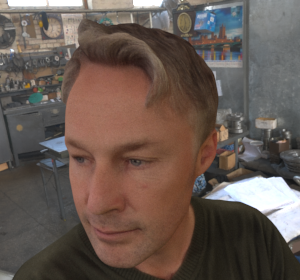

In [3]:
# loading random image from headsegmentation test dataset as pipeline input
n_classes = len(segmentation_labels.labels)
dataset_path = config.DATASET_PATH
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
_, X_test, _, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
rnd = False
i_ref = 2056
i = random.randint(0, len(X_test) - 1) if rnd is True else i_ref
input = Image.open(X_test[i]).convert('RGB')
input

In [4]:
# executing pipeline
retrieved_clothes_paths = pl.execute(input)
print(f'Found {len(retrieved_clothes_paths)} clothes for query {query}.')

100%|██████████| 169/169 [01:33<00:00,  1.82it/s]


Found 1587 clothes for query upper_body.


Showing first 50 retrieved clothes.


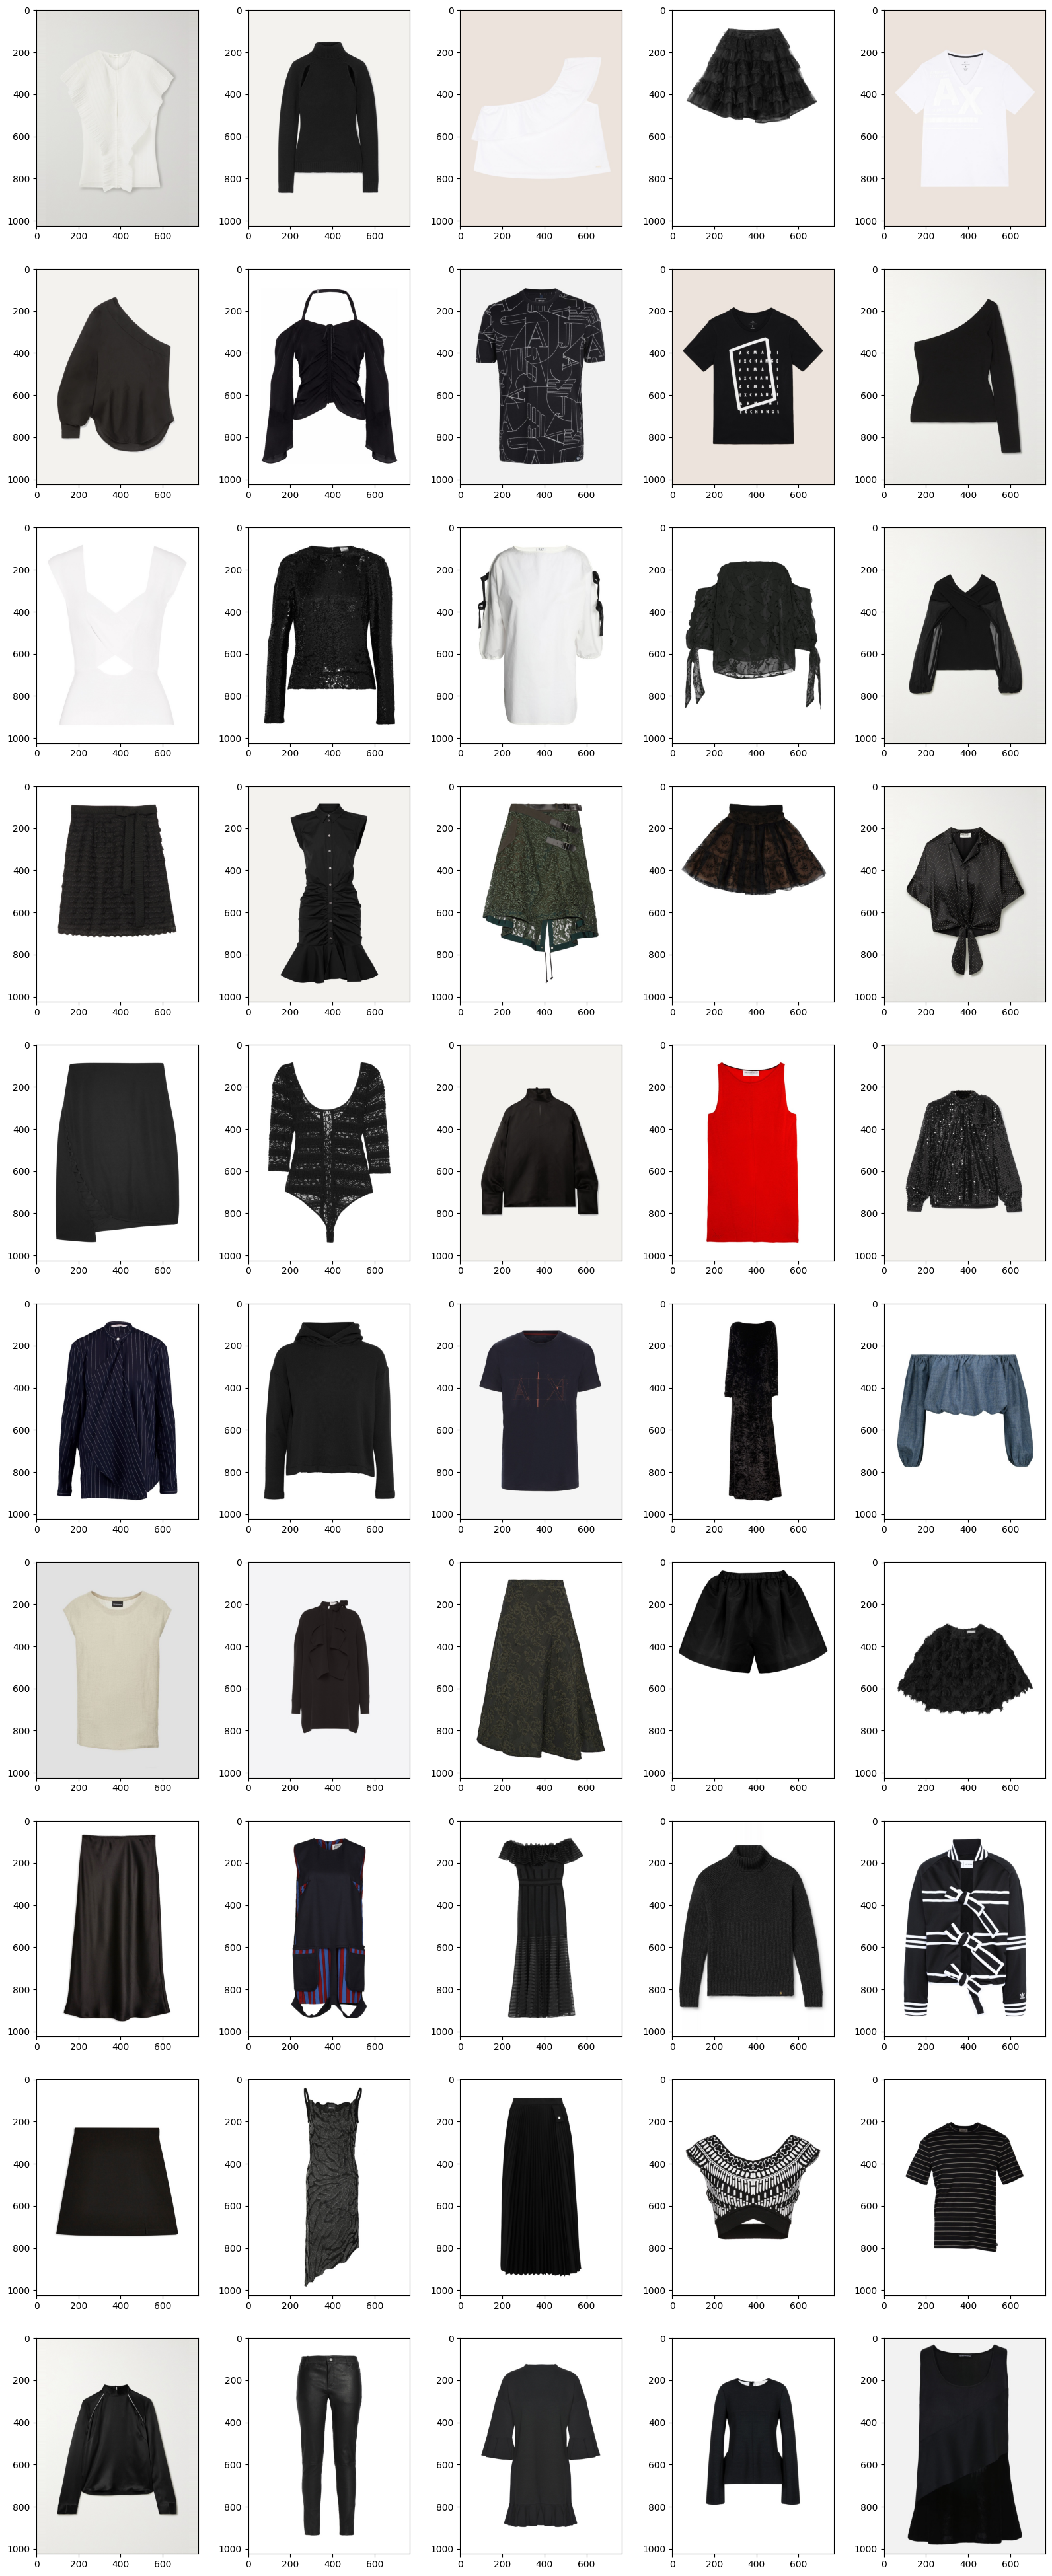

In [6]:
n_results = 50

# plotting first n_results retrieved clothing items
i = 1
n_columns = min(n_results, 5)
n_rows = n_results // n_columns
print(f'Showing first {n_results} retrieved clothes.')
plt.figure(figsize=(20, 5 * n_rows))
for c in range(1, n_columns + 1):
    for r in range(1, n_rows + 1):
        plt.subplot(n_rows, n_columns, i)
        img = Image.open(retrieved_clothes_paths[i-1]).convert('RGB')
        plt.imshow(img)
        i += 1